## Information Retrieval and NLP

Information Retrieval(IR) is not only an important part of text Data Mining but it also has an extensive application in Natural Language Processing(NLP). This is because every NLP pipiline implements text normalization as an important preprocessing step.

A few important definitions before we get started:

- A **word** is a string of characters that appears in a text/sentence/paragraph, etc. (We all know this one!)
- A **term** is a normalized word i.e. a word that has gone through preprocessing. For example: "studying"(A word) becomes "study"(A term after a certain kind of normalization).
- A **token** can be thought of a unique instance of a word or a term. For example, the set {'hannah','is','the','queen','of','the','Kingdom'} has 7 words but 6 tokens(because 'the' is repeated).
- Two words are of the same **type** if they fall under the same equivalence class or become the same term after normalization. For example, Studies, Study and Studying could be of the same type after performing some kind of normalization.


### Why perform normalization?
Because we want to retreieve all documents relevant to the user's query. For example, ff the user searches for "U.S.A" not only do we want all documents with that specific query, we may also want documents with "USA" and "United States of America" and "North America" and maybe even "the States"!

This notebook will walk you through some commonly used methods for text normalization and IR. We will be using te 'Disaster Tweets" dataset from Kaggle which can be found at: https://www.kaggle.com/datasets/vstepanenko/disaster-tweets

Enjoy!

In [6]:
# let's import necessary libraries

# nltk stands for Natural Language Tookit. this library is commonly used for text normalization
import nltk

# for arrays and dataframes
import numpy as np     
import pandas as pd    

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
# let's import the disaster tweets dataset from Kaggle

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train.csv', index_col = False)
df_test = pd.read_csv('Data\\disaster_tweets_kaggle\\test.csv', index_col = False)

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [95]:
# Since test data does not have a target column we will only use training data
# drop the 'id' column
df_train.drop(['id'], axis = 1, inplace = True)

In [96]:
df_train.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

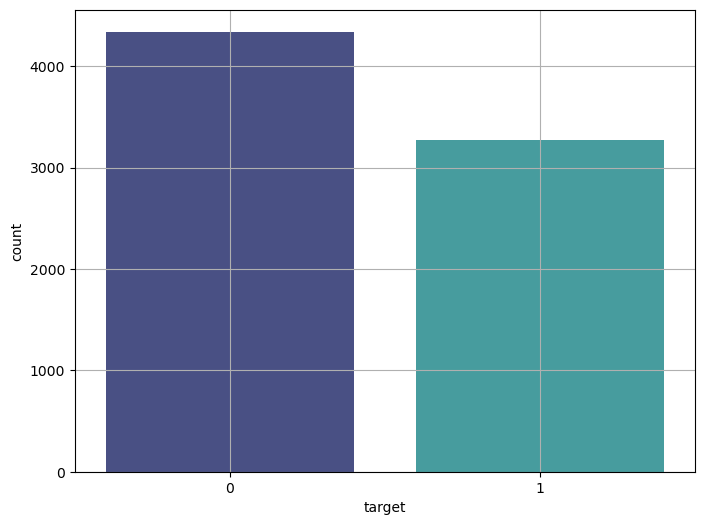

In [97]:
# let's look at distribution of the target variable
plt.figure(figsize = (8,6))
sns.countplot(data = df_train, x = 'target', palette = "mako")
plt.grid()

<Axes: >

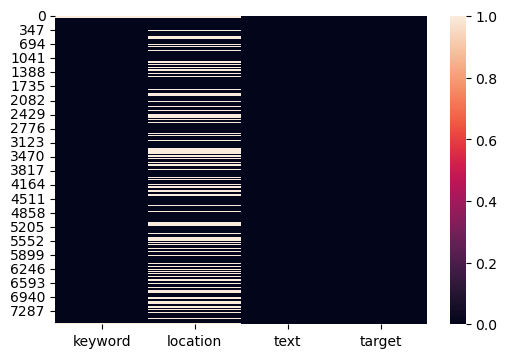

In [98]:
# let's visualize the missing values
plt.figure(figsize = (6,4))
sns.heatmap(df_train.isnull(), cmap = "rocket")

keyword       26
location    1105
text           0
dtype: int64


<Axes: >

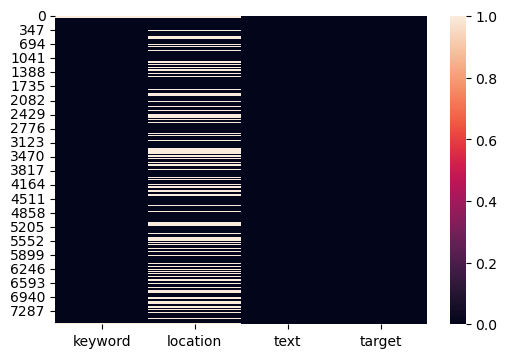

In [99]:
# let's check the test data
print(df_test.isnull().sum())
plt.figure(figsize = (6,4))
sns.heatmap(df_train.isnull(), cmap = "rocket")

In [100]:
# Let's check if majority of the null locations belong to a specific target
df_train[df_train['location'].isnull()].groupby('target').count()

,keyword,location,text
target,,,
0,1439,0,1458
1,1033,0,1075


In [101]:
# since that's not he case and there are too many missing valus for column 'location' we will drop this
df_train.drop(labels = ['location'], axis = 1, inplace = True)

In [102]:
# to deal with missing values in 'keyword' let's look at the most common keywords in both targets
df_train[df_train['target'] == 1].groupby('keyword').count()

,text,target
keyword,,
ablaze,13,13
accident,24,24
airplane%20accident,30,30
ambulance,20,20
annihilated,11,11
...,...,...
wounded,26,26
wounds,10,10
wreck,7,7


In [103]:
df_train[df_train['target'] == 0].groupby('keyword').count()

,text,target
keyword,,
ablaze,23,23
accident,11,11
aftershock,34,34
airplane%20accident,5,5
ambulance,18,18
...,...,...
windstorm,24,24
wounded,11,11
wounds,23,23


We can see that almost all keywords are related to disaster and present in both groups. Therefore, the tweet ext will be used to impute any keywords if present.

In [104]:
# save keywords as a list but we only want keywords that are not null
keywords_list = list((df_train[df_train['keyword'].isnull() == False]['keyword']).unique())

In [105]:
# check length to confirm only unique words are present
len(keywords_list)

221

In [106]:
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [107]:
# we will fill null values for 'keyword' based on the list of present keywords that was just created
def get_clean_text(raw_text):
    
    # remove hyperlink
    text_c1 = raw_text.split('http')[0].strip()
    
    # remove username
    text_c2 = ' '.join([word for word in text_c1.split() if '@' not in word])
    
    # remove all other punctuation
    text_c3 = ''.join([ch for ch in text_c2 if ch not in string.punctuation])
    
    # remove numbers
    text_c4 = ' '.join([word for word in text_c3.split() if not word.isnumeric()])
    
    # convert text to lowercase
    text_c5 = text_c4.lower()
    
    return text_c5
    
def impute_keyword(df):
    keyword = df[0]
    text = get_clean_text(df[1])
    
    if pd.isnull(keyword):            # if keyword === null
        for item in keywords_list:    
            if item.lower() in text.lower():          # of the tweet contains any keyword from the keyword list
                return item
    return keyword


In [108]:
# impute leyword for both training and test data
df_train['keyword'] = df_train[['keyword', 'text']].apply(impute_keyword, axis = 1)

In [109]:
# let's check if any null values were replaced
print("Train:", df_train['keyword'].isnull().sum())   

Train: 20
Test: 9


We cal see that more than half of the null values were replaced. Let's look at the remaining tweets with null values.

In [110]:
df_train[df_train['keyword'].isnull()]['text']

10            Three people died from the heat wave so far
15                                         What's up man?
16                                          I love fruits
17                                       Summer is lovely
18                                      My car is so fast
19                           What a goooooooaaaaaal!!!!!!
20                                 this is ridiculous....
21                                      London is cool ;)
22                                            Love skiing
23                                  What a wonderful day!
24                                               LOOOOOOL
25                         No way...I can't eat that shit
26                                  Was in NYC last week!
27                                     Love my girlfriend
28                                              Cooool :)
29                                     Do you like pasta?
30                                               The end!
7591    Heat w

We can just drop these values.

In [111]:
df_train.dropna(axis = 0, inplace = True)
df_train.reset_index(drop = True, inplace = True)
df_train.isnull().sum()

keyword    0
text       0
target     0
dtype: int64

Now that we have imputed all keywords possible for the training and test data, we can perform normalization.

## Common techniques for text data normalization

#### 1. Tokelization
This is the process of converting a text/sentence or a string od characters into a list of words/tokens. We will also use delimiters to remove "#", quolations, etc.

#### 2. Case Folding
Reducing all letters to upper/lower case.

#### 3. Removing Stop Words
Stop words are common words like 'the','in','on','at', etc. which generally have little value when it comes to IR. However, these are found to be useful in finding patterns or meaning during deep learning.

#### 4. Lemmatization
Reducing a word/token into it's dictionary headword form i.e. lemma. For example: cars, car's -> car; cutting -> cut; etc.

#### 5. Stemming
Cutting off words at the end to acheive "principled" lemmatization. It si a faster way of acheiving lemmatization and does not depend on context. However, it may not always give sensible results in some cases. Exampe: reduction -> reduc (stemming) but reduction -> reduce (lemmatization)

**To replace the remaining null values in the 'Keyword' column we will only use tokenization, case folding and stop word removal for now.**

In [112]:
from nltk.corpus import stopwords     # to remove stopwords

In [113]:
def normalize(text, stemming = 1, stopword_removal = 1, tokenize = 0):
    
    # first create a list of characters without punctuation
    char_list = [ch for ch in text if ch not in string.punctuation]
    
    # join to re create a text without punctuation
    text = ''.join(char_list)
    
    # case folding
    lower_cased_text = text.casefold()
    
    if stopword_removal == 1:
        # tokenize and remove stopwords
        word_list = [word for word in lower_cased_text.split() if word not in stopwords.words('english')]
        
    if stemming == 1:
        stemmer = PorterStemmer()
        word_list = [stemmer.stem(word) for word in word_list]
        
    if tokenize == 1:
        return word_list
  
    return ' '.join(word_list)


In [114]:
#let's test it
normalize(df_train['text'][1], 1, 1, 0)

'forest fire near la rong sask canada'

In [115]:
# create new column with normalized text
df_train['text_norm'] = df_train['text'].apply(normalize)

In [116]:
df_train.head()

,keyword,text,target,text_norm
0,earthquake,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,fire,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,evacuation,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,evacuation,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california
4,fire,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [117]:
# also replace keywords with stemmed keywords
stemmer = PorterStemmer()
df_train['stemmed_keyword'] = pd.Series(stemmer.stem(keyword) for keyword in df_train['keyword'])

In [118]:
df_train.head()

,keyword,text,target,text_norm,stemmed_keyword
0,earthquake,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak
1,fire,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire
2,evacuation,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu
3,evacuation,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu
4,fire,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire


In [119]:
# drop original keyword column
# the original text column will not be dropped it may be useful for feature engineering
df_train.drop(['keyword'], axis = 1, inplace = True)
df_train.head()

,text,target,text_norm,stemmed_keyword
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire


## Save normalized data

In [120]:
df_train.to_csv('Data\\disaster_tweets_kaggle\\train_norm.csv', index = False)